In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
from tqdm import tqdm
import itertools
import matplotlib.ticker as ticker

text_font = 15
mpl.rcParams.update({'font.size': text_font, 'font.style': 'normal', 'font.family':'sans-serif'})

dat_path = os.getcwd() + '/data_sna/'
fig_path = os.getcwd() + '/figures/'

### Notebook structure

##### Requirements 
- IBD graph and NePRA graph
- Tool usage dataset for each of the 15 (3 non-tool, 9 simple, and 3 complex) tool types.

##### Functions
- edge overlap from tool sharing to IBD (Fig3A)
- edge overlap from tool sharing to NePRA (Fig3B)
- edge overlap from IBD to tool sharing (Fig3C)
- edge overlap from NePRA to tool sharing (Fig3D)

##### Results
- Tool sharing strongly predicts the presence of genetic (IBD or NePRA) relationships.
- Genetic relationships do not predict the presence of tool sharing (cultural) links.

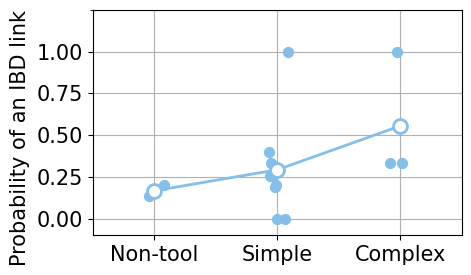

In [8]:
def fig3A():
	
	'''
	Generates a scatter and line plot to visualize the probability of an IBD (Identical by Descent) link for different tool categories.

	Steps:
	1. Load IBD network data and create a graph.
	2. For each tool category, load tool data and calculate the proportion of connected site pairs also known as reinforcement analysis.
	3. Plot the results and save the figure as 'fig3A.png'.
	'''

	ori_color = '#83bfe9'
	rnd_color = '#83bfe9'
	aff_list = ['nontool', 'simple', 'complex']

	network_dat = pd.read_csv(dat_path+'/IBD_edgelist.csv', delimiter=';')
	IBD_graph = nx.from_pandas_edgelist(network_dat, 'site1', 'site2')

	_full_dat = [[] for x in range(len(aff_list))]

	for aff in aff_list:
		_tool_dat = pd.read_csv(dat_path+f'{aff}_aff.csv', delimiter=';')
		_tool_dat = _tool_dat.rename(columns={'Unnamed: 0': 'site'})

		_tool_list = list(_tool_dat.columns[1:])


		for tool in _tool_list:
			
			# Select the columns 'site' and the current tool from the tool data
			this_tool_dat = _tool_dat[['site', tool]]

			# Filter the data to include only rows where the tool is present (value is 1)
			this_tool_dat = this_tool_dat[this_tool_dat[tool] == 1]

			# Generate all possible pairs of sites where the tool is present, this will represent shared cultural links
			this_tool_all_edges = list(itertools.combinations(this_tool_dat['site'], 2))

			# If there are no pairs, print a message and continue to the next tool
			if len(this_tool_all_edges) == 0:
				print(f'{aff} {tool} has no edges')
				continue

			# Initialize a counter for the number of edges found in the IBD graph
			count = 0

			# Check each pair to see if it exists as an edge in the IBD graph, i.e. do the reinforcement analysis
			for edge in this_tool_all_edges:
				if (IBD_graph.has_edge(edge[0], edge[1])) or (IBD_graph.has_edge(edge[1], edge[0])):
					count += 1

			# Calculate the proportion of pairs that are connected in the IBD graph and store it
			_full_dat[aff_list.index(aff)].append(count / len(this_tool_all_edges))


	fig, ax = plt.subplots(1, 1, figsize=(5, 3))

	shift = 0.1

	#original data
	for i in range(3):
		x_ticks = [np.random.uniform(i-shift, i+shift) for x in range(len(_full_dat[i]))]
		ax.scatter(x_ticks, _full_dat[i], marker='o', color=ori_color, s=50, zorder = 2)

	x_ticks = [0, 1, 2]
	y_dat = [np.mean(_full_dat[0]), np.mean(_full_dat[1]), np.mean(_full_dat[2])]
	ax.plot(x_ticks, y_dat, color=ori_color, linewidth=2, 
			marker='o', markersize=10, markerfacecolor='white', markeredgewidth=2, zorder=10)
	

	ax.set_xticks(x_ticks, ['Non-tool', 'Simple', 'Complex'], fontsize=text_font)


	ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
	ax.set_ylabel('Probability of an IBD link', fontsize=text_font)
	ax.set_xlim(-0.5, 2.5)
	ax.set_ylim(-0.1, 1.25)

	ax = plt.gca()  # Get the current Axes instance
	ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
	ax.yaxis.set_label_coords(-0.17, 0.43)

	ax.plot([], [], marker='o',color=ori_color, label='data', linestyle='-', linewidth=2)
	ax.plot([], [], marker='o', color=rnd_color, label='randomized', linestyle='--', linewidth=2, alpha=0.8)

	# plt.legend(fontsize=text_font, loc='upper center', bbox_to_anchor=(0.55, 1.03), ncol=2, frameon=False, handletextpad=0.5, columnspacing=1.5, labelspacing=0.5, handlelength=2.5, borderpad=0.5)

	plt.grid(which='both')
	plt.tight_layout()
	# plt.savefig(fig_path + 'fig3A.png', dpi=600, bbox_inches='tight', format='png')
	plt.show()
	plt.close()

fig3A()

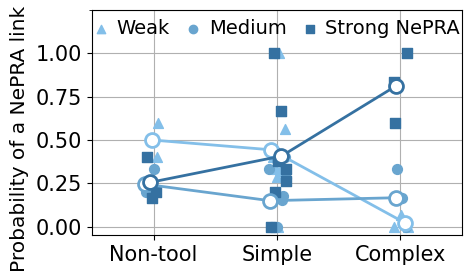

In [9]:
def fig_3B():

	'''
    Generates a scatter and line plot to visualize the probability of a NePRA (Nearly private rare alleles) link for different tool categories and link strengths.

    Steps:
    1. Load NePRA network data and categorize it by link strength.
    2. For each tool category, load tool data and calculate the proportion of connected site pairs for each link strength.
    3. Plot the results and save the figure as 'fig3B.png'.
    '''

	aff_list = ['nontool', 'simple', 'complex']
	link_strength_list = ['Weak', 'Medium', 'Strong NePRA']
	
	marker_list = ['^','o','s']
	color_list = ['#83bfe9', '#69a5cf', '#3571a1' ]

	network_dat = pd.read_csv(dat_path+'/NePRA_edgelist.csv', delimiter=';')

	_full_dat_w, _full_dat_m, _full_dat_s = ([[] for x in range(len(aff_list))] for y in range(3))


	for link_strength in link_strength_list:

		# Categorize the NePRA network data by link strength as weak, medium, or strong

		if link_strength == 'Weak':
			this_network_dat = network_dat[network_dat['neprasimilarity'] < 0.0006]
		elif link_strength == 'Medium':
			this_network_dat = network_dat[(network_dat['neprasimilarity'] >= 0.0006) & (network_dat['neprasimilarity'] < 0.002)]
		elif link_strength == 'Strong NePRA':
			this_network_dat = network_dat[network_dat['neprasimilarity'] >= 0.002]

		NePRA_graph = nx.from_pandas_edgelist(this_network_dat, 'site1', 'site2')

		
		for aff in aff_list:
			_tool_dat = pd.read_csv(dat_path+f'{aff}_aff.csv', delimiter=';')
			_tool_dat = _tool_dat.rename(columns={'Unnamed: 0': 'site'})

			_tool_list = list(_tool_dat.columns[1:])


			for tool in _tool_list:

				####### full data
				# Select the columns 'site' and the current tool from the tool data
				this_tool_dat = _tool_dat[['site', tool]]

				# Filter the data to include only rows where the tool is present (value is 1)
				this_tool_dat = this_tool_dat[this_tool_dat[tool] == 1]

				# Generate all possible pairs of sites where the tool is present
				this_tool_all_edges = list(itertools.combinations(this_tool_dat['site'], 2))

				# If there are no pairs, print a message and continue to the next tool
				if len(this_tool_all_edges) == 0:
					print(f'{aff} {tool} has no edges')
					continue

				# Initialize a counter for the number of edges found in the NePRA graph
				count = 0

				# Check each pair to see if it exists as an edge in the NePRA graph
				for edge in this_tool_all_edges:
					if (NePRA_graph.has_edge(edge[0], edge[1])) or (NePRA_graph.has_edge(edge[1], edge[0])):
						count += 1

				# Store the proportion of pairs that are connected in the NePRA graph based on link strength
				if link_strength == 'Weak':
					_full_dat_w[aff_list.index(aff)].append(count / len(this_tool_all_edges))
				elif link_strength == 'Medium':
					_full_dat_m[aff_list.index(aff)].append(count / len(this_tool_all_edges))
				elif link_strength == 'Strong NePRA':
					_full_dat_s[aff_list.index(aff)].append(count / len(this_tool_all_edges))


	fig, ax = plt.subplots(1, 1, figsize=(5, 3))
	shift = 0.07

	for f, _full_dat in enumerate([_full_dat_w, _full_dat_m, _full_dat_s]):
		for i in range(len(aff_list)):
			x_ticks = [np.random.uniform(i-shift, i+shift) for x in range(len(_full_dat[i]))]
			ax.scatter(x_ticks, _full_dat[i], marker=marker_list[f], color=color_list[f], s=50, zorder = 2)


	for f, _full_dat in enumerate([_full_dat_w, _full_dat_m, _full_dat_s]):
		x_ticks = [np.random.uniform(i-shift, i+shift) for i in range(len(aff_list))]
		ax.plot(x_ticks, [np.mean(_full_dat[0]), np.mean(_full_dat[1]), np.mean(_full_dat[2])], color=color_list[f], 
				linewidth=2, marker='o', markersize=10, markerfacecolor='white', markeredgewidth=2, zorder=10)
		
	for i in range(len(link_strength_list)):
		ax.scatter([], [], marker=marker_list[i], color=color_list[i], label=link_strength_list[i])

	ax.legend(fontsize=text_font-1, loc='upper center', bbox_to_anchor=(0.39, 0.82, 0.2, 0.2), ncol=3, 
			frameon=False, handletextpad=0.05, columnspacing=0.45, labelspacing=0.05, handlelength=1.5, borderpad=0.2)

	ax.set_xticks([0, 1, 2], ['Non-tool', 'Simple', 'Complex'], fontsize=text_font)


	ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
	ax.set_ylabel('Probability of a NePRA link', fontsize=text_font-0.5)
	ax.set_xlim(-0.5, 2.5)
	ax.set_ylim(-0.05, 1.25)

	ax = plt.gca()  # Get the current Axes instance
	ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
	ax.yaxis.set_label_coords(-0.17, 0.43)


	plt.grid(which='both')
	plt.tight_layout()
	# plt.savefig(fig_path + 'fig3B.png', dpi=600, bbox_inches='tight', format='png')
	plt.show()
	plt.close()

fig_3B()

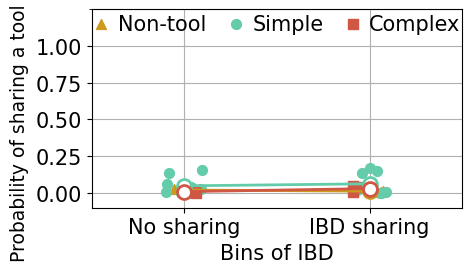

In [10]:
def fig3C():

	'''
    Generates a scatter and line plot to visualize the probability of tool sharing for different tool categories with and without IBD (Identity by Descent) sharing.

    Steps:
    1. Load IBD network data and create graphs for IBD and its complement.
    2. For each tool category, load tool data and calculate the proportion of shared tools for IBD and non-IBD pairs.
    3. Plot the results and save the figure as 'fig3C.png'.
    '''

	aff_list = ['nontool', 'simple', 'complex']
	label_list = ['Non-tool', 'Simple', 'Complex']

	color_list = ['#cc9a1d', '#65ccab', '#d15745']
	marker_list = ['^', 'o', 's']

	network_dat = pd.read_csv(dat_path+'/IBD_edgelist.csv', delimiter=';')

	IBD_graph = nx.from_pandas_edgelist(network_dat, 'site1', 'site2')
	IBD_graph_edges = list(IBD_graph.edges())


	# Create a complement graph for the IBD graph. A complement graph has all the edges that are not present in the original graph.
	IBD_graph_complement = nx.complement(IBD_graph)
	IBD_graph_complement_edges = list(IBD_graph_complement.edges())


	_full_dat = [[] for x in range(len(aff_list))]
	_full_dat_complement = [[] for x in range(len(aff_list))]

	for aff in aff_list:
		_tool_dat = pd.read_csv(dat_path+f'{aff}_aff.csv', delimiter=';')
		_tool_dat = _tool_dat.rename(columns={'Unnamed: 0': 'site'})

		_tool_list = list(_tool_dat.columns[1:])


		for tool in _tool_list:

			#####original data
			# Select the columns 'site' and the current tool from the tool data
			this_tool_dat = _tool_dat[['site', tool]]

			# Filter the data to include only rows where the tool is present (value is 1)
			this_tool_dat = this_tool_dat[this_tool_dat[tool] == 1]

			# Generate all possible pairs of sites where the tool is present
			this_tool_all_edges = list(itertools.combinations(this_tool_dat['site'], 2))

			# Create a graph from the pairs of sites where the tool is present
			this_tool_graph = nx.Graph(this_tool_all_edges)

			# Initialize a counter for the number of edges found in the IBD graph
			count = 0

			# Check each edge in the IBD graph to see if it exists in the tool graph
			for edge in IBD_graph_edges:
				if (this_tool_graph.has_edge(edge[0], edge[1])) or (this_tool_graph.has_edge(edge[1], edge[0])):
					count += 1

			# Store the proportion of IBD graph edges that are also in the tool graph
			_full_dat[aff_list.index(aff)].append(count / len(IBD_graph_edges))

			# Initialize a counter for the number of edges found in the IBD graph complement
			count = 0

			# Check each edge in the IBD graph complement to see if it exists in the tool graph
			for edge in IBD_graph_complement_edges:
				if (this_tool_graph.has_edge(edge[0], edge[1])) or (this_tool_graph.has_edge(edge[1], edge[0])):
					count += 1

			# Store the proportion of IBD graph complement edges that are also in the tool graph
			_full_dat_complement[aff_list.index(aff)].append(count / len(IBD_graph_complement_edges))


	fig, ax = plt.subplots(1, 1, figsize=(5, 3))

	shift = 0.1

	
	for i in range(3):

		##original data plot
		x_ticks = [np.random.uniform(0-shift, 0+shift) for x in range(len(_full_dat_complement[i]))]
		ax.scatter(x_ticks, _full_dat_complement[i], marker=marker_list[i], color=color_list[i], s=50, zorder = 2)

		x_ticks = [np.random.uniform(1-shift, 1+shift) for x in range(len(_full_dat[i]))]
		ax.scatter(x_ticks, _full_dat[i], marker=marker_list[i], color=color_list[i], s=50, zorder = 2, label=label_list[i])

		ax.plot([0, 1], [np.mean(_full_dat_complement[i]), np.mean(_full_dat[i])], color=color_list[i], 
			linewidth=2, marker='o', markersize=10, markerfacecolor='white', markeredgewidth=2, zorder=10)
		x_shift = 0.1


	ax.set_xticks([0, 1], ['No sharing', 'IBD sharing'], fontsize=text_font)
	ax.set_xlabel('Bins of IBD', fontsize=text_font)


	ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
	ax.set_ylabel('Probability of sharing a tool', fontsize=text_font-1.5)
	ax.yaxis.set_label_coords(-0.17, 0.38)
	ax.set_xlim(-0.5, 1.5)
	ax.set_ylim(-0.1, 1.25)

	ax = plt.gca()  # Get the current Axes instance
	ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
	plt.grid(which='both')

	first_legend = plt.legend(fontsize=text_font, loc='upper center', bbox_to_anchor=(0.49, 1.05), ncol=3, frameon=False, handletextpad=0.05, columnspacing=0.65, labelspacing=0.05, handlelength=1.5, borderpad=0.2)



	plt.tight_layout()
	# plt.savefig(fig_path + 'fig3C.png', dpi=600, bbox_inches='tight', format='png')
	plt.show()
	plt.close()

fig3C() 

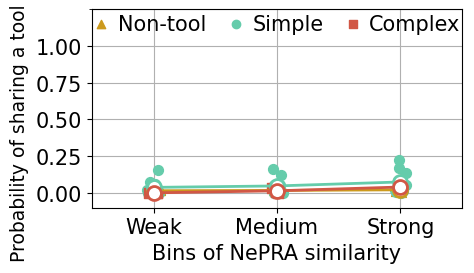

In [11]:
def fig3D():

	'''
    Generates a scatter and line plot to visualize the probability of tool sharing for different tool categories across varying NePRA (Network-based Pairwise Relatedness Analysis) similarity bins.

    Steps:
    1. Load NePRA network data and categorize it by similarity strength.
    2. For each tool category, load tool data and calculate the proportion of shared tools for each NePRA similarity bin.
    3. Plot the results and save the figure as 'fig3D.png'.
    '''

	aff_list = ['nontool', 'simple', 'complex']
	color_list = ['#cc9a1d', '#65ccab', '#d15745']#['#febf25', '#60cda7', '#8a3f29']
	marker_list = ['^', 'o', 's']

	network_dat = pd.read_csv(dat_path+'/NePRA_edgelist.csv', delimiter=';')

	_full_dat_w, _full_dat_m, _full_dat_s = ([[] for x in range(len(aff_list))] for y in range(3))


	weak_network_dat = network_dat[network_dat['neprasimilarity'] < 0.0006]
	medium_network_dat = network_dat[(network_dat['neprasimilarity'] >= 0.0006) & (network_dat['neprasimilarity'] < 0.002)]
	strong_network_dat = network_dat[network_dat['neprasimilarity'] >= 0.002]

	NePRA_graph_weak = nx.from_pandas_edgelist(weak_network_dat, 'site1', 'site2')
	NePRA_graph_medium = nx.from_pandas_edgelist(medium_network_dat, 'site1', 'site2')
	NePRA_graph_strong = nx.from_pandas_edgelist(strong_network_dat, 'site1', 'site2')

	NePRA_graph_weak_edges = list(NePRA_graph_weak.edges())
	NePRA_graph_medium_edges = list(NePRA_graph_medium.edges())
	NePRA_graph_strong_edges = list(NePRA_graph_strong.edges())

	for aff in aff_list:
		_tool_dat = pd.read_csv(dat_path+f'{aff}_aff.csv', delimiter=';')
		_tool_dat = _tool_dat.rename(columns={'Unnamed: 0': 'site'})

		_tool_list = list(_tool_dat.columns[1:])


		for tool in _tool_list:
			this_tool_dat = _tool_dat[['site', tool]]
			this_tool_dat = this_tool_dat[this_tool_dat[tool] == 1]

			this_tool_all_edges = list(itertools.combinations(this_tool_dat['site'], 2))
			this_tool_graph = nx.Graph(this_tool_all_edges)

			for this_graph_edges, _full_dat in zip([NePRA_graph_weak_edges, NePRA_graph_medium_edges, NePRA_graph_strong_edges], [_full_dat_w, _full_dat_m, _full_dat_s]):
				count = 0
				for edge in this_graph_edges:
					if (this_tool_graph.has_edge(edge[0], edge[1])) or (this_tool_graph.has_edge(edge[1], edge[0])):
						count += 1
				_full_dat[aff_list.index(aff)].append(count/len(this_graph_edges))


	fig, ax = plt.subplots(1, 1, figsize=(5, 3))
	shift = 0.05

	for f, _full_dat in enumerate([_full_dat_w, _full_dat_m, _full_dat_s]):
		for i in range(3):
			x_ticks = [np.random.uniform(f-shift, f+shift) for x in range(len(_full_dat[i]))]
			ax.scatter(x_ticks, _full_dat[i], marker=marker_list[i], color=color_list[i], s=50, zorder = 2)

	for i in range(3):
		ax.plot([0,1,2], [np.mean(_full_dat_w[i]), np.mean(_full_dat_m[i]), np.mean(_full_dat_s[i])], color=color_list[i], linewidth=2, zorder=np.inf, marker='o', markersize=10, markerfacecolor='white', markeredgewidth=2)

	label_list = ['Non-tool', 'Simple', 'Complex']
	for i in range(3):
		ax.scatter([], [], marker=marker_list[i], color=color_list[i], label=label_list[i])



	ax.set_xticks(range(3), ['Weak', 'Medium', 'Strong'], fontsize=text_font)
	ax.set_xlabel('Bins of NePRA similarity', fontsize=text_font)


	ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
	ax.set_ylabel('Probability of sharing a tool', fontsize=text_font-1.5)
	ax.yaxis.set_label_coords(-0.17, 0.38)
	ax.set_xlim(-0.5, 2.5)
	ax.set_ylim(-0.1, 1.25)

	ax = plt.gca()  # Get the current Axes instance
	ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
	plt.grid(which='both')

	plt.legend(fontsize=text_font, loc='upper center', bbox_to_anchor=(0.49, 1.05), ncol=3, frameon=False, handletextpad=0.05, columnspacing=0.65, labelspacing=0.05, handlelength=1.5, borderpad=0.2)
	
	plt.tight_layout()
	# plt.savefig(fig_path + 'fig3D.png', dpi=600, bbox_inches='tight', format='png')
	plt.show()
	plt.close()

fig3D() 